# Library imports

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import glob
from dask import dataframe as dd

In [2]:
file_path=os.path.join("..","data","valeurs-foncieres")
file_list=glob.glob(file_path+"/*.txt")
file_list

['../data/valeurs-foncieres/valeursfoncieres-2018.txt',
 '../data/valeurs-foncieres/valeursfoncieres-2017.txt',
 '../data/valeurs-foncieres/valeursfoncieres-2015-s2.txt',
 '../data/valeurs-foncieres/valeursfoncieres-2016.txt',
 '../data/valeurs-foncieres/valeursfoncieres-2019.txt']

In [101]:
data_main=pd.read_csv(file_list[0],sep="|",decimal=",")
data_main=data_main[data_main["Code postal"]>=75000]
data_main=data_main[data_main["Code postal"]<76000]
data_main["Surface_carrez_totale"]=data_main[["Surface Carrez du 1er lot","Surface Carrez du 2eme lot","Surface Carrez du 3eme lot","Surface Carrez du 4eme lot","Surface Carrez du 5eme lot"]].sum(axis=1,skipna=True)
for a in tqdm(range(1,len(file_list))):
    temp=pd.read_csv(file_list[a],sep="|",decimal=",")
    temp=temp[temp["Code postal"]>=75000]
    temp=temp[temp["Code postal"]<76000]
    temp["Surface_carrez_totale"]=temp[["Surface Carrez du 1er lot","Surface Carrez du 2eme lot","Surface Carrez du 3eme lot","Surface Carrez du 4eme lot","Surface Carrez du 5eme lot"]].sum(axis=1,skipna=True)
    data_main=pd.concat([data_main,temp])
    
data=data_main[['Date mutation', 'Nature mutation', 'Valeur fonciere', 'No voie', 'Code voie', 'Voie', 'Code commune','Nombre de lots','Code type local','Surface_carrez_totale', 'Nombre pieces principales']]

/home/nicolasrx/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (14,18,23,24,26,28,32,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
  0%|          | 0/4 [00:00<?, ?it/s]/home/nicolasrx/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (18,23,24,26,28,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
 25%|██▌       | 1/4 [00:08<00:25,  8.46s/it]/home/nicolasrx/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (18,23,24,26,28,30,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
 50%|█████  

In [102]:
data=pd.concat([data,pd.get_dummies(data["Nature mutation"],prefix="nature_mutation_")],axis=1)
data=pd.concat([data,pd.get_dummies(data["Code commune"],prefix="code_commune_")],axis=1)
data=pd.concat([data,pd.get_dummies(data["Code type local"],prefix="type_local_")],axis=1)
#data=pd.concat([data,pd.get_dummies(data["Code voie"],prefix="code_voie_")])
data.drop(["Date mutation","Nature mutation","Code commune","Code type local",'Code voie'],axis=1,inplace=True)
data=data[data["Surface_carrez_totale"]>0]
#data.info()

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157477 entries, 3041468 to 3142950
Data columns (total 37 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   Valeur fonciere                                      157398 non-null  float64
 1   No voie                                              157470 non-null  float64
 2   Nombre de lots                                       157477 non-null  int64  
 3   Surface_carrez_totale                                157477 non-null  float64
 4   Nombre pieces principales                            157074 non-null  float64
 5   nature_mutation__Adjudication                        157477 non-null  uint8  
 6   nature_mutation__Echange                             157477 non-null  uint8  
 7   nature_mutation__Expropriation                       157477 non-null  uint8  
 8   nature_mutation__Vente                         

In [117]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer


y=data["Valeur fonciere"]
addresses=pd.DataFrame(data["Voie"],columns=["Voie"])
X=data.drop(["Valeur fonciere","Voie"],axis=1)

impy = SimpleImputer(missing_values=np.nan, strategy='mean')
y=np.array(y).reshape(len(y),1)
y = impy.fit_transform(y)

impx = SimpleImputer(missing_values=np.nan, strategy='mean')
X = pd.DataFrame(impx.fit_transform(X),columns=X.columns,index=addresses.index)
y=pd.DataFrame(y/np.array(data["Surface_carrez_totale"]).reshape(len(y),1),columns=["Price_m2"],index=addresses.index)

In [118]:
map_data=pd.concat([X,y,addresses],axis=1)
average_street_cost=map_data.groupby("Voie").mean()

In [119]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import keras
# Define a function

def model(input_dim):

    tf.keras.backend.clear_session()
    tf.random.set_seed(60)
    model=keras.models.Sequential([

        keras.layers.Dense(256, input_dim = input_dim),
        keras.layers.LeakyReLU(),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        
        keras.layers.Dense(256),
        keras.layers.LeakyReLU(),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        
        keras.layers.Dense(units=128),
        keras.layers.LeakyReLU(),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        
        keras.layers.Dense(units=128,activation='relu'),
        keras.layers.LeakyReLU(),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        
        keras.layers.Dense(units=64),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units=1, activation="linear")])
    
    return model


my_model = model(input_dim=X.shape[1])

my_model.summary()
optimizer = keras.optimizers.Adam(lr=0.005, decay=5e-4)

checkpoint_name = 'Weights\Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

my_model.compile(loss="mse" , optimizer=optimizer, metrics=['mse','mae'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               9472      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Split
y=np.array(y).reshape(len(y),1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scale the input features
xscaler = StandardScaler()
X_train = xscaler.fit_transform(X_train)
X_test = xscaler.transform(X_test)

yscaler=StandardScaler()
y_train=yscaler.fit_transform(y_train)
y_test=yscaler.transform(y_test)

# Train the model, iterating on the data in batches of 32 samples
history =my_model.fit(X_train, y_train,
                    epochs=50, batch_size=512,
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks_list,
                    verbose=1)

ValueError: Input contains infinity or a value too large for dtype('float64').

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [122]:
from folium.plugins import HeatMap
from plotnine import *
from geopandas import GeoDataFrame

In [123]:
shp_path = os.path.join("..","data","valeurs-foncieres",'gis_osm_roads_free_1.shp')
roads = GeoDataFrame.from_file(shp_path, encoding='utf-8')
roads.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,2569,5115,tertiary,Rue Nationale,None,F,50,0,F,F,"LINESTRING (2.36944 48.82153, 2.36942 48.82159..."
1,2570,5114,secondary,Avenue des Gobelins,None,F,50,0,F,F,"LINESTRING (2.35517 48.83202, 2.35531 48.83183)"
2,2573,5122,residential,Place des Alpes,None,F,30,0,F,F,"LINESTRING (2.35858 48.83216, 2.35855 48.83218..."
3,2574,5115,tertiary,Rue Taine,None,B,50,0,F,F,"LINESTRING (2.39454 48.83943, 2.39430 48.83927..."
4,286314,5122,residential,Rue Saint-Louis en l'Île,None,B,50,0,F,F,"LINESTRING (2.36009 48.85041, 2.36007 48.85046)"


In [124]:
print(roads["name"][300:370])

300        Quai de l'Archevêché
301           Rue du Chevaleret
302          Rue de la Chapelle
303                Rue Proudhon
304                  Rue Bruant
                 ...           
365            Rue Jeanne d'Arc
366        Passage Commun AS/13
367       Boulevard Saint-Denis
368    Boulevard Vincent Auriol
369              Rue Abel Gance
Name: name, Length: 70, dtype: object


In [125]:
center = [48.85537, 2.35422]
top = 48.900404
bottom = 48.79120
left = 2.282760
right = 2.417716

In [126]:
import folium
import shapely.affinity
from shapely.geometry import Point
import geopy
import geopy.distance

# create an ellipse
radius_lat = geopy.distance.distance(kilometers = 10).destination(point=center, bearing=0)[0] - center[0]
radius_lon = geopy.distance.distance(kilometers = 10).destination(point=center, bearing=90)[1] - center[1]

circle = Point(center[::-1]).buffer(1)
ellipse = shapely.affinity.scale(circle, radius_lon, radius_lat)

ellipse_map = folium.Map(location=center, zoom_start=10, tiles='CartoDB positron')

folium.PolyLine(list([c[::-1] for c in ellipse.exterior.coords])).add_to(ellipse_map)

ellipse_map

In [127]:
paris = roads.loc[roads['geometry'].apply(lambda g: ellipse.contains(g))].copy()
paris.shape

(106793, 11)

In [128]:
paris = paris[paris.fclass.isin(['trunk', 'primary','secondary','tertiary']) | paris['name'].notnull()]
paris['name'] = paris['name'].fillna(value='')
paris.shape

(47412, 11)

In [144]:
paris['prefix'] = paris['name'].apply(lambda name: name.split(' ')[0] if name is not None else None)
paris['suffix'] = paris['name'].apply(lambda name: " ".join(name.split(' ')[1:]).upper() if name is not None else None)

In [162]:
def get_designation(name):
    name = name.lower()
    if 'rue' in name: return 'rue'
    elif 'avenue' in name: return 'avenue'
    elif 'allée' in name: return 'allée'
    elif 'place' in name: return 'place'
    elif 'boulevard' in name: return 'boulevard'
    elif 'passage' in name: return 'passage'
    elif 'quai' in name: return 'quai'
    elif 'route' in name: return 'route'
    else: return "autre"


paris['designation'] = [get_designation(name) for name in paris['name']]

In [163]:
paris.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,prefix,suffix,designation,Price_m2
0,2569,5115,tertiary,Rue Nationale,None,F,50,0,F,F,"LINESTRING (2.36944 48.82153, 2.36942 48.82159...",Rue,NATIONALE,rue,0.0
1,2570,5114,secondary,Avenue des Gobelins,None,F,50,0,F,F,"LINESTRING (2.35517 48.83202, 2.35531 48.83183)",Avenue,DES GOBELINS,avenue,0.0
2,2573,5122,residential,Place des Alpes,None,F,30,0,F,F,"LINESTRING (2.35858 48.83216, 2.35855 48.83218...",Place,DES ALPES,place,0.0
3,2574,5115,tertiary,Rue Taine,None,B,50,0,F,F,"LINESTRING (2.39454 48.83943, 2.39430 48.83927...",Rue,TAINE,rue,0.0
4,286314,5122,residential,Rue Saint-Louis en l'Île,None,B,50,0,F,F,"LINESTRING (2.36009 48.85041, 2.36007 48.85046)",Rue,SAINT-LOUIS EN L'ÎLE,rue,0.0


In [168]:
colors = {
    'rue': '#59c8e5',
    'avenue': '#59c8e5',
    'allée': '#fed032',
    'place': '#fec301',
    'boulevard': '#fe4d64',
    'passage': '#ffb366',
    'quai': '#ff9223',
    'route': '#0a7abf',
    'autre': '#cccccc'
}

In [153]:
#average_street_cost=average_street_cost.Price_m2
average_street_cost

Voie
A 11                7926.540931
A 12                9232.630868
AB 20               8392.816736
ABEL               19754.478463
ABEL HOVELACQUE     8726.163028
                       ...     
YVES DU MANOIR      6625.714902
YVES TOUDIC        15059.583962
YVON VILLARCEAU    10339.691625
YVONNE LE TAC      11467.989102
Z 20                7907.673034
Name: Price_m2, Length: 3337, dtype: float64

In [164]:
temp=paris
temp["Price_m2"]=np.zeros(len(temp))
j=0
for i in tqdm(range(len(temp))):
    if temp.iloc[i,:]["suffix"] in list(average_street_cost.index):
        temp.iloc[i,:]["Price_m2"]=average_street_cost[temp.iloc[i,:]["suffix"]]
        j=j+1
print(j/len(temp))
paris["Price_m2"]=temp["Price_m2"]
        
    
    

  0%|          | 0/47412 [00:00<?, ?it/s]/home/nicolasrx/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 47412/47412 [00:32<00:00, 1447.63it/s]

0.30580865603644647


In [179]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


def plot_and_save(data,top,bottom,left,right,linewidth,linewidth_lane,legend_title,legend_bbox,path,colors,dpi=300):
    
    top = cm.get_cmap('Oranges_r', 128)
    bottom = cm.get_cmap('Blues', 128)

    newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                           bottom(np.linspace(0, 1, 128))))
    newcmp = ListedColormap(newcolors, name='OrangeBlue')
    
    f, ax = plt.subplots(1, figsize=(15, 15))

    data.plot(ax=ax,colormap=newcmp,linewidth=[linewidth if d == 'place' else linewidth_lane for d in data.designation])
    ax.set_aspect(1/math.cos(math.pi/180*center[0]))
    ax.set_ylim((bottom, top))
    ax.set_xlim((left, right))
    plt.axis('off')
    plt.legend(handles=[mpatches.Patch(color=colors[k], label=k) for k in colors],
               loc='center right',fontsize='large', edgecolor='none', title=legend_title,title_fontsize='xx-large',bbox_to_anchor=legend_bbox)

    plt.savefig(path, bbox_inches='tight', dpi=dpi)

/home/nicolasrx/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/geopandas/plotting.py:630: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)


TypeError: '>' not supported between instances of 'LinearSegmentedColormap' and 'LinearSegmentedColormap'

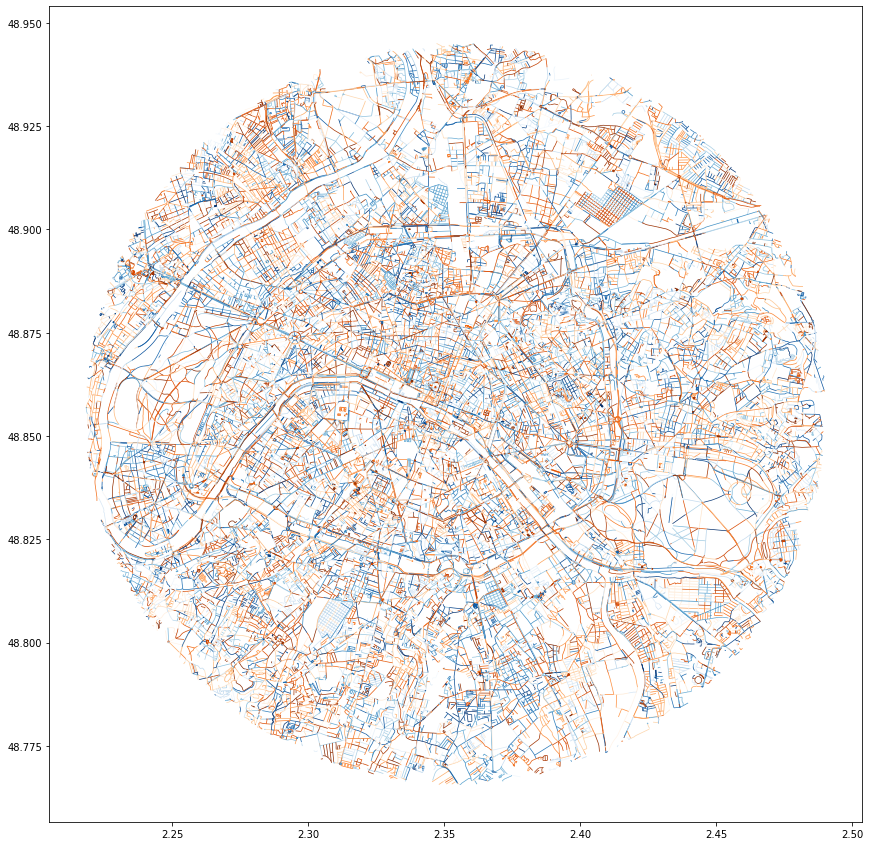

In [180]:
plot_and_save(paris,top,bottom,left,right,
              1,0.7,'Paris',(1.25, 0.5),'paris.png',colors=colors)